#import libraries

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import get_file
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [108]:
# import csv file
df1 = pd.read_csv('yelp_reviews.csv', nrows=100000)

In [109]:
df1.shape

(100000, 9)

#data cleaning

In [110]:
df1.head(6)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [111]:
df2 = df1.drop(['review_id','user_id','business_id','useful','funny','cool','date'] ,axis=1 , inplace=False)

In [112]:
df2.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


In [113]:
# checking null values
df2.isnull().sum()

stars    0
text     0
dtype: int64

In [114]:
#checking duplicates
df2.duplicated().sum()

34

In [115]:
#Removing duplicates
df3 = df2.drop_duplicates(inplace=False)

In [116]:
df3.duplicated().sum()

0

In [117]:
df3.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


<Axes: title={'center': 'Review Stars'}, xlabel='stars'>

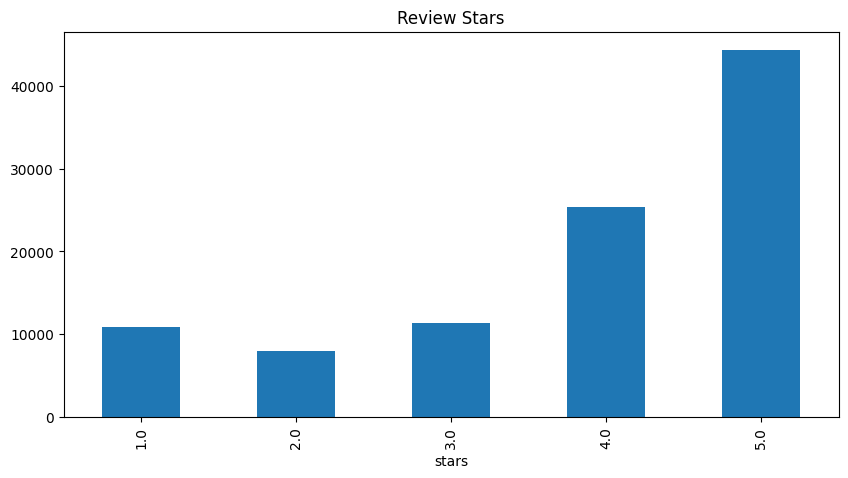

In [118]:
df3['stars'].value_counts().sort_index().plot(kind='bar', title="Review Stars", figsize=(10,5))

#dividing starts into negative neutral positive

In [119]:
# 0 - negative
# 1 - neutral
# 2 - positive

# Function to convert score to sentiment
def sentiment(rating):
    
    rating = int(rating)
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df3['sentiment'] = df3['stars'].apply(sentiment)

C:\Users\Genuka K Manthila\AppData\Local\Temp\ipykernel_11724\4007003634.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sentiment'] = df3['stars'].apply(sentiment)


In [120]:
df3.head(5)

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2


In [121]:
# checking new sentiment values
df3['sentiment'].value_counts().sort_index()

sentiment
0    18902
1    11361
2    69703
Name: count, dtype: int64

In [122]:
# taking sample data set
df4=df3.iloc[:10000]
df4

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2
...,...,...,...
9995,5.0,Excellent food and service. The place is funct...,2
9996,5.0,Just about to get tucked into a meatloaf that ...,2
9997,5.0,Outstanding customer service! And my car is dr...,2
9998,5.0,I and my husband went here for Dinner one day ...,2


In [123]:
df4['sentiment'].value_counts().sort_index()

sentiment
0    1842
1    1139
2    7019
Name: count, dtype: int64

In [124]:
df5=df4[['text']]

#data preprocessing

In [125]:
from transformers import XLNetTokenizer, XLNetModel, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [126]:
# Tokenizer and Model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
base_xlnet_model = XLNetModel.from_pretrained('xlnet-base-cased')


In [127]:
dropout_prob = 0.20  # You can adjust the dropout probability
base_xlnet_model.dropout = torch.nn.Dropout(dropout_prob)

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [129]:
base_xlnet_model.to(device)

XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0-11): 12 x XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [130]:
def tokenize_data(data):
    input_ids = []
    attention_masks = []

    for index, row in data.iterrows():
        review = row['text']

        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(df5)

batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

In [131]:
# Check if M1 GPU is available; if not, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

# Define optimizer and loss function
optimizer = AdamW(base_xlnet_model.parameters(), lr=2e-5, eps=1e-8)

# Move the model to the appropriate device
base_xlnet_model.to(device)

Using device: cpu


c:\Users\Genuka K Manthila\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0-11): 12 x XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [132]:
import numpy as np
from tqdm import tqdm

# Model training
num_epochs = 5  # 
early_stopping_patience = 3 
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    base_xlnet_model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch

        optimizer.zero_grad()

        outputs = base_xlnet_model(input_ids, attention_mask=attention_mask)
        loss = outputs.last_hidden_state.mean()  # You can use a different reconstruction loss here

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {average_loss:.4f}')

    # Early Stopping Check
    if average_loss < best_loss:
        best_loss = average_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping after {epoch + 1} epochs without improvement.')
        break

Epoch 1: 100%|██████████| 313/313 [1:42:46<00:00, 19.70s/it]


Epoch 1 - Average Loss: -0.4038


Epoch 2: 100%|██████████| 313/313 [1:42:56<00:00, 19.73s/it]


Epoch 2 - Average Loss: -0.4243


Epoch 3: 100%|██████████| 313/313 [1:38:03<00:00, 18.80s/it]


Epoch 3 - Average Loss: -0.4330


Epoch 4: 100%|██████████| 313/313 [1:40:29<00:00, 19.26s/it]


Epoch 4 - Average Loss: -0.4414


Epoch 5: 100%|██████████| 313/313 [1:41:40<00:00, 19.49s/it]

Epoch 5 - Average Loss: -0.4496


In [144]:
torch.save(base_xlnet_model, 'XLnet.pth')

In [145]:
model = torch.load('XLnet.pth')
model.to(device) 

XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0-11): 12 x XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Generating Embeddings: 100%|██████████| 313/313 [35:55<00:00,  6.89s/it]
c:\Users\Genuka K Manthila\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Genuka K Manthila\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Genuka K Manthila\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X

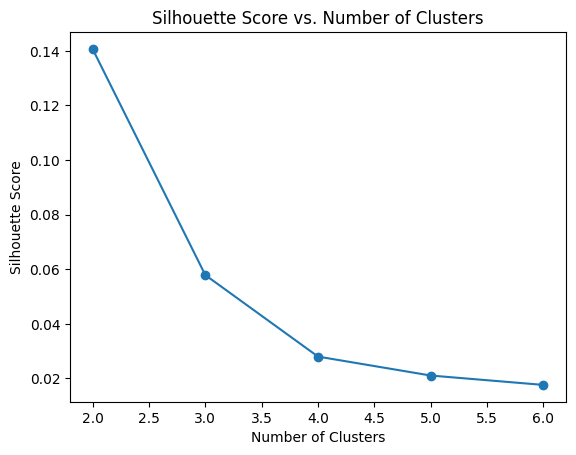

In [146]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc='Generating Embeddings'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)

# Evaluate Clustering for Different Numbers of Clusters
max_clusters = 6 # You can adjust this based on your requirements
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [147]:
# Apply Clustering (Example: K-Means)
num_clusters = 3  # You can adjust this based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Evaluate Clustering (Example: Silhouette Score)
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

c:\Users\Genuka K Manthila\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.0579


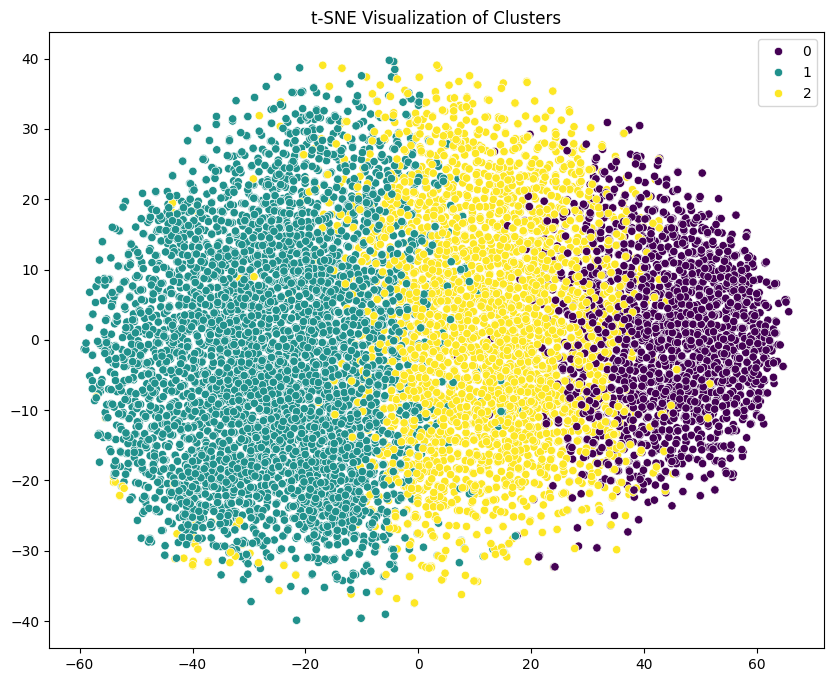

In [148]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize Clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Clusters')
plt.show()

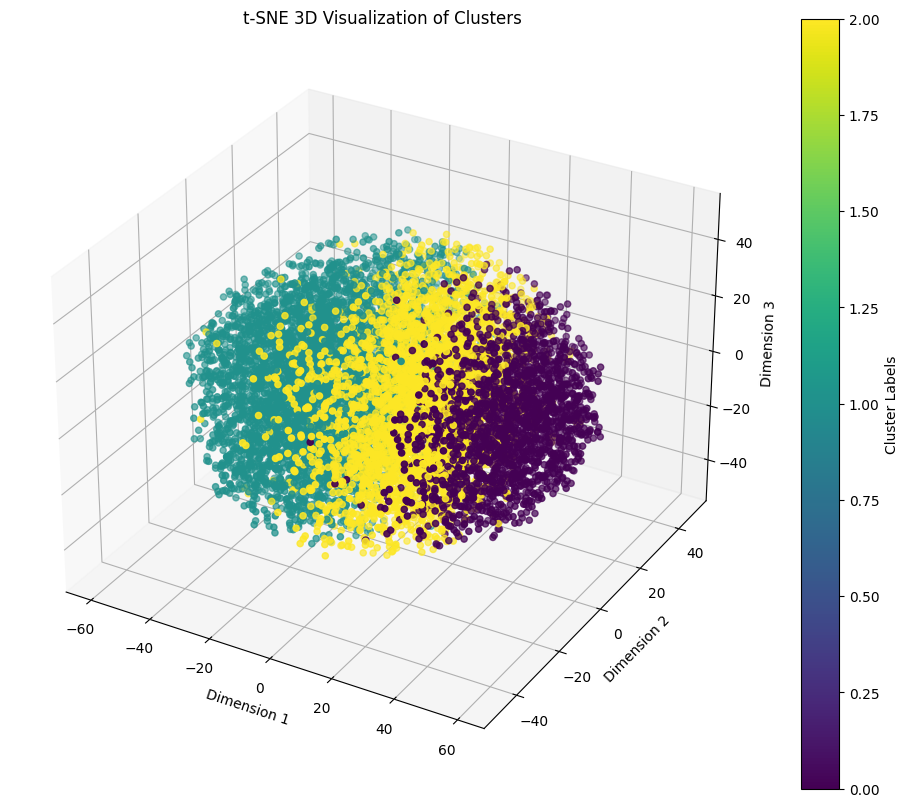

In [150]:
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings)

# Visualize Clusters in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embeddings_3d[:, 0],
    embeddings_3d[:, 1],
    embeddings_3d[:, 2],
    c=cluster_labels,
    cmap='viridis'
)

ax.set_title('t-SNE 3D Visualization of Clusters')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

plt.show()

In [149]:
inertia = kmeans.inertia_
print(f'Inertia: {inertia:.4f}')

Inertia: 532.1341


In [170]:
def predict_text(input_text):
    model.eval()

    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

    encoded_data = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    cluster_label = kmeans.predict(embeddings.reshape(1, -1))[0]

    return cluster_label

# Example usage
new_text = "reasturant is normal"
predicted_cluster = predict_text(new_text)
print(f"Predicted Cluster: {predicted_cluster}")

Predicted Cluster: 2
